In [2]:
import os
import glob
import numpy as np
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kagglehub
import torchvision
from torchinfo import summary
from torchvision.utils import save_image
from torchvision.models import VGG16_Weights



from CNNVAE import CNNVAE
from VAE import VAE
from VAE_less_complicated import VariationalAutoencoder,VariationalAutoencoderLoss

from GAN import GAN

/Users/dawid/PycharmProjects/ImbalancedDataProject/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Parametry modelu
IMG_SIZE = 128
CHANNELS = 3
LATENT_DIM = 256
HIDDEN_DIM = 1024
BATCH_SIZE = 16
EPOCHS = 100
PATIENCE = 70  # Liczba epok bez poprawy, po których trening się zatrzyma

# Konfiguracja
result_dir = 'results/'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)



name = 'vae'
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)

if torch.backends.mps.is_available():
    torch.mps.empty_cache()

print(f"Training device: {device}")

Training device: mps


# Dataset

(128, 128, 3)


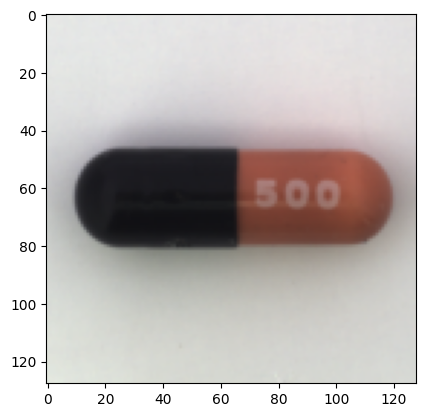

In [4]:
class CapsuleNegativeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = glob.glob(os.path.join(root_dir, '*'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image
    
if CHANNELS==3:
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
else:
    normalize = transforms.Normalize(mean=[0.5], std=[0.5])

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    normalize
])

# Ścieżka do danych (zmień na swoją)

path = kagglehub.dataset_download("tladilebohang/capsule-defects")

dataset = CapsuleNegativeDataset(
    root_dir=os.path.join(path, 'capsule/negative'),
    transform=transform
)

# Podział danych
full_indices = np.arange(len(dataset))
train_val_indices, test_indices = train_test_split(
    full_indices, test_size=0.2, random_state=42, shuffle=True
)
train_indices, val_indices = train_test_split(
    train_val_indices, test_size=0.2, random_state=42, shuffle=True
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


#Print first image
data_iter = iter(train_loader)
images = next(data_iter)  # 

image = images[0]

image = (image+1)/2

image = image.permute(1, 2, 0).numpy()
image = np.array(image)
print(image.shape)

plt.imshow(image)


# VAE

In [5]:
BCE_loss = nn.BCELoss(reduction='sum')
MSE_loss = nn.MSELoss(reduction='sum')


# Funkcja strat z modelem, ktory porownuje ekstaktowane cechy 
def CNN_loss(self,recon_x, x, mu, logvar, perceptual_loss):
    # Perceptual Loss dla cech
    percep_loss = perceptual_loss(recon_x, x)

    # Standardowa strata VAE (BCE + KLD)
    bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Ważone sumowanie (można dostosować wagi)
    return 0.7 * percep_loss + 0.3 * bce + 0.1* kld


#Do testowania
def loss_tmp(recon_x, x, mu, logvar):
    # BCE = F.binary_cross_entropy(recon_x, x,reduction='sum')
    # BCE = F.mse_loss(recon_x, x, size_average=False)
    #BCE = BCE_loss(recon_x, x)
    MSE = MSE_loss(recon_x, x)
    
    MSE=MSE/x.size(0)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD




def loss_from_article(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD



In [6]:

class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # Używamy warstw VGG16 do ekstrakcji cech (bez warstw fully connected)
        self.vgg = torchvision.models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features[:16].eval()
        # Zamrażamy wagi VGG (nie chcemy ich trenować)
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, recon, target):

        # Ekstrakcja cech
        recon_features = self.vgg(recon)
        target_features = self.vgg(target)

        # Strata to MSE między cechami
        return F.mse_loss(recon_features, target_features)

In [7]:
# Inicjalizacja
perceptual_loss = PerceptualLoss().to(device)
#variational_autoencoder_loss = VariationalAutoencoderLoss()

model = VAE().to(device)
#model = CNNVAE().to(device)

# model = VariationalAutoencoder(
#     n_data_features=CHANNELS*IMG_SIZE * IMG_SIZE,  # MNIST pixels
#     n_encoder_hidden_features=HIDDEN_DIM,  # chosen arbitrarily
#     n_decoder_hidden_features=HIDDEN_DIM,  # chosen arbitrarily
#     n_latent_features=LATENT_DIM,  # how many features will be used to represent input
# ).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dummy_input = torch.zeros(1, CHANNELS, IMG_SIZE, IMG_SIZE).to(device)  
summary(model, input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 3, 128, 128]          --
├─Sequential: 1-1                        [1, 512]                  --
│    └─Linear: 2-1                       [1, 1024]                 50,332,672
│    └─ReLU: 2-2                         [1, 1024]                 --
│    └─Dropout: 2-3                      [1, 1024]                 --
│    └─Linear: 2-4                       [1, 870]                  891,750
│    └─ReLU: 2-5                         [1, 870]                  --
│    └─Dropout: 2-6                      [1, 870]                  --
│    └─Linear: 2-7                       [1, 665]                  579,215
│    └─ReLU: 2-8                         [1, 665]                  --
│    └─Dropout: 2-9                      [1, 665]                  --
│    └─Linear: 2-10                      [1, 512]                  340,992
│    └─ReLU: 2-11                        [1, 512]             

In [8]:
# Trenowanie
def train(epoch):
    model.train()
    train_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon ,mu,logvar = model(data)
        loss = loss_tmp(recon_x=recon, x=data,mu=mu,logvar=logvar)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    print(f'Train Epoch: {epoch} | Loss: {train_loss:.4f}')
    return train_loss
    


def validate(epoch):
    model.eval()
    validate_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            recon ,mu,logvar = model(data)
            validate_loss += loss_tmp(recon_x=recon, x=data,mu=mu,logvar=logvar).item()

    validate_loss /= len(val_loader.dataset)
    print(f'Validate Epoch: {epoch} | Loss: {validate_loss:.4f}')
    return validate_loss

# Wizualizacja rekonstrukcji
def visualize_reconstruction(epoch):
    model.eval()
    with torch.no_grad():
        sample = next(iter(train_loader)).to(device)

        recon ,mu,logvar = model(sample)
        
        recon = (recon + 1) / 2

        fig, axes = plt.subplots(2, BATCH_SIZE, figsize=(32, 8))
        for i in range(BATCH_SIZE):
            axes[0, i].imshow(((sample[i]+1)/2).cpu().permute(1, 2, 0))
            axes[0, i].axis('off')
            axes[1, i].imshow(recon[i].cpu().permute(1, 2, 0))
            axes[1, i].axis('off')
        plt.savefig(f'{result_dir}/recon_{epoch}.png')
        plt.close()

# Pętla treningowa VAE

In [9]:
# Główna pętla
best_loss = float('inf')
no_improve = 0  # Licznik epok bez poprawy

for epoch in range(1, EPOCHS + 1):
    train_loss=train(epoch)
    validate_loss = validate(epoch)
    visualize_reconstruction(epoch)

    # Zapisywanie najlepszego modelu
    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model.state_dict(), f'{result_dir}/{name}_best.pth')
        no_improve = 0  
    else:
        no_improve += 1

    # Early stopping
    if no_improve >= PATIENCE:
        print(f'\nEarly stopping after {PATIENCE} epochs without improvement')
        break

    print(f'Epoch {epoch}: Train Loss = {train_loss:.4f} (Best: {best_loss:.4f})')

Train Epoch: 1 | Loss: 70714244.7793
Validate Epoch: 1 | Loss: 359.9958
Epoch 1: Train Loss = 70714244.7793 (Best: 70714244.7793)
Train Epoch: 2 | Loss: 124.5660
Validate Epoch: 2 | Loss: 555.2550
Epoch 2: Train Loss = 124.5660 (Best: 124.5660)
Train Epoch: 3 | Loss: 115.1410
Validate Epoch: 3 | Loss: 175.3644
Epoch 3: Train Loss = 115.1410 (Best: 115.1410)
Train Epoch: 4 | Loss: 94.3489
Validate Epoch: 4 | Loss: 226.4179
Epoch 4: Train Loss = 94.3489 (Best: 94.3489)
Train Epoch: 5 | Loss: 205.5679
Validate Epoch: 5 | Loss: 173.1383
Epoch 5: Train Loss = 205.5679 (Best: 94.3489)
Train Epoch: 6 | Loss: 74.8199
Validate Epoch: 6 | Loss: 310.1772
Epoch 6: Train Loss = 74.8199 (Best: 74.8199)
Train Epoch: 7 | Loss: 80.5611
Validate Epoch: 7 | Loss: 72.7615
Epoch 7: Train Loss = 80.5611 (Best: 74.8199)
Train Epoch: 8 | Loss: 50.5387
Validate Epoch: 8 | Loss: 196.5961
Epoch 8: Train Loss = 50.5387 (Best: 50.5387)
Train Epoch: 9 | Loss: 47.4175
Validate Epoch: 9 | Loss: 416.0964
Epoch 9: Trai

In [ ]:
# Ocena na zbiorze testowym
model.load_state_dict(torch.load(f'{result_dir}/{name}_best.pth'))
model.eval()
test_loss = 0
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        recon, mu, logvar = model(data)
        print(mu.mean(),logvar.mean())
        test_loss += loss_tmp(recon, data, mu, logvar).item()/ len(data)

print(f'Final Test Loss: {test_loss / len(test_loader.dataset):.4f}')

In [ ]:
def generate_from_params(model, mu, logvar, num_samples=1, device='cpu'):
    """
    Generuje próbki z rozkładu N(mu, exp(logvar))
    
    Args:
        model: VAE model
        mu: tensor (LATENT_DIM,) - średnia
        logvar: tensor (LATENT_DIM,) - log-wariancja
        num_samples: int - liczba próbek do wygenerowania
        device: str - urządzenie (cpu/cuda)
    Returns:
        Tensor (num_samples, CHANNELS, IMG_SIZE, IMG_SIZE)
    """
    model.eval()
    with torch.no_grad():
        # Rozszerz mu i logvar dla num_samples
        mu = mu.unsqueeze(0).expand(num_samples, -1).to(device)          # (num_samples, LATENT_DIM)
        logvar = logvar.unsqueeze(0).expand(num_samples, -1).to(device)  # (num_samples, LATENT_DIM)

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # (num_samples, LATENT_DIM)
        z = mu + eps * std

        samples = model.decode(z)    # (num_samples, CHANNELS, IMG_SIZE, IMG_SIZE)
    return samples

In [ ]:
def generate_from_accurate_params(model, mu, logvar, num_samples=1, device='cpu'):
    """
    Generuje próbki z rozkładu N(mu, exp(logvar))
    
    Args:
        model: VAE model
        mu: tensor (LATENT_DIM,) - średnia
        logvar: tensor (LATENT_DIM,) - log-wariancja
        num_samples: int - liczba próbek do wygenerowania
        device: str - urządzenie (cpu/cuda)
    Returns:
        Tensor (num_samples, CHANNELS, IMG_SIZE, IMG_SIZE)
    """
    model.eval()
    with torch.no_grad():
        
        mu = mu.expand(num_samples, -1).to(device)          # kształt: [5, latent_dim]
        logvar = logvar.expand(num_samples, -1).to(device)  # kształt: [5, latent_dim]

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # (num_samples, LATENT_DIM)
        z = mu + eps * std

        samples = model.decode(z)    # (num_samples, CHANNELS, IMG_SIZE, IMG_SIZE)
    return samples

In [ ]:
def save_samples(samples, output_dir=result_dir):
    for i, sample in enumerate(samples):
        # Zapis do pliku PNG
        save_image(sample, os.path.join(output_dir, f"sample_{i}.png"))

In [ ]:
# Przykład użycia:
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
desired_variance = 0.5
desired_mu = 0.3

vae = VAE().to(device)
state_dict = torch.load(result_dir+'vae_best.pth', map_location='cpu')
vae.load_state_dict(state_dict)
vae.eval()

mu = torch.log(torch.tensor(desired_mu)) * torch.ones(LATENT_DIM).to(device)
logvar = torch.log(torch.tensor(desired_variance)) * torch.ones(LATENT_DIM).to(device)
samples = generate_from_params(vae, mu, logvar, num_samples=5, device=device)

save_samples(samples)

In [ ]:
# Przykład użycia:
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)


vae = VAE().to(device)
state_dict = torch.load(result_dir+'vae_best.pth', map_location='cpu')
vae.load_state_dict(state_dict)
vae.eval()

data = next(iter(test_loader)).to(device)
tmp_image = data[0]  # Zakładając, że data[0] to obrazy z batcha

# Dodaj wymiar batcha, jeśli obraz jest pojedynczy
tmp_image = tmp_image.unsqueeze(0)  # Dodaje wymiar batcha na początku



# Upewnij się, że obraz jest na odpowiednim urządzeniu
tmp_image = tmp_image.to(device)

# Przekazujemy obraz do modelu
recon, mu, logvar = model(tmp_image)

samples = generate_from_accurate_params(vae, mu, logvar, num_samples=5, device=device)

save_samples(samples)

# GAN


In [4]:
gan=GAN(IMG_SIZE,CHANNELS,LATENT_DIM,device)


In [7]:
# Pętla główna
best_g_loss = float('inf')
best_d_loss = float('inf')
no_improve = 0  # Licznik epok bez poprawy

for epoch in range(1, EPOCHS + 1):
    
    g_loss, d_loss = gan.train_gan(epoch,dataloader=train_loader)

    # Walidacja
    validate_loss = gan.validate(epoch, val_loader)

    # Wizualizacja rekonstrukcji
    gan.visualize_reconstruction(epoch)

    if g_loss < best_g_loss:
        best_g_loss = g_loss
        gan.save_generator()
        no_improve = 0
    else:
        no_improve += 1

    if d_loss < best_d_loss:
        best_d_loss = d_loss
        gan.save_discriminator()
        no_improve = 0
    else:
        no_improve += 1

    # Early stopping
    if no_improve >= PATIENCE:
        print(f'\nEarly stopping after {PATIENCE} epochs without improvement')
        break

    print(f'Epoch {epoch}: Validation Loss = {validate_loss:.4f} Generator Loss = {g_loss:.4f}, Discriminator Loss = {d_loss:.4f} \n (Best G: {best_g_loss:.4f} Best D: {best_d_loss:.4f}) ')


Epoch 1: Generator Loss = 0.8963, Discriminator Loss = 0.8142
Epoch 1: Validation Loss = 0.6317
Epoch 1: Validation Loss = 0.6317 Generator Loss = 0.8963, Discriminator Loss = 0.8142 
 (Best G: 0.8963 Best D: 0.8142) 
Epoch 2: Generator Loss = 1.1794, Discriminator Loss = 0.6722
Epoch 2: Validation Loss = 0.9936
Epoch 2: Validation Loss = 0.9936 Generator Loss = 1.1794, Discriminator Loss = 0.6722 
 (Best G: 0.8963 Best D: 0.6722) 
Epoch 3: Generator Loss = 0.8170, Discriminator Loss = 0.7763
Epoch 3: Validation Loss = 0.6119
Epoch 3: Validation Loss = 0.6119 Generator Loss = 0.8170, Discriminator Loss = 0.7763 
 (Best G: 0.8170 Best D: 0.6722) 
Epoch 4: Generator Loss = 0.9292, Discriminator Loss = 0.5513
Epoch 4: Validation Loss = 0.5745
Epoch 4: Validation Loss = 0.5745 Generator Loss = 0.9292, Discriminator Loss = 0.5513 
 (Best G: 0.8170 Best D: 0.5513) 
Epoch 5: Generator Loss = 0.9873, Discriminator Loss = 0.7431
Epoch 5: Validation Loss = 0.6776
Epoch 5: Validation Loss = 0.677